# Вычисление индивидуальной вероятности аварии для клиента

## Установка библиотек

In [ ]:
!pip install -q kaggle
!pip install -q geopandas
!pip install -q plotly_express
!pip install -q osmnx
!pip install -q catboost
!pip install -q dataframe-image

     |████████████████████████████████| 1.0MB 7.7MB/s 
     |████████████████████████████████| 6.6MB 26.6MB/s 
     |████████████████████████████████| 15.4MB 237kB/s 
     |████████████████████████████████| 102kB 6.0MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 10.3MB 42.9MB/s 
     |████████████████████████████████| 1.0MB 24.3MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 69.2MB 92kB/s 


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import plotly_express as px
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
ox.config(use_cache=True, log_console=True)
import numpy as np
from geopy import Nominatim as nm
import requests as req
import os
import random
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
import seaborn as sns
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn

Загрузим данные об авариях в Нью-Йорке

In [ ]:
data_ny_collisions = pd.read_csv('https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD')
data_ny_collisions.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,04/14/2021,5:32,NaN,NaN,NaN,NaN,NaN,BRONX WHITESTONE BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4407480,Sedan,Sedan,NaN,NaN,NaN
1,04/13/2021,21:35,BROOKLYN,11217,40.68358,-73.97617,"(40.68358, -73.97617)",NaN,NaN,620 ATLANTIC AVENUE,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4407147,Sedan,NaN,NaN,NaN,NaN
2,04/15/2021,16:15,NaN,NaN,NaN,NaN,NaN,HUTCHINSON RIVER PARKWAY,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Pavement Slippery,NaN,NaN,NaN,NaN,4407665,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
3,04/13/2021,16:00,BROOKLYN,11222,NaN,NaN,NaN,VANDERVORT AVENUE,ANTHONY STREET,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4407811,Sedan,NaN,NaN,NaN,NaN
4,04/12/2021,8:25,NaN,NaN,0.00000,0.00000,"(0.0, 0.0)",EDSON AVENUE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4406885,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN


In [ ]:
data_manhattan = data_ny_collisions[data_ny_collisions['BOROUGH'] == 'MANHATTAN']

In [ ]:
def create_graph(loc, dist, transport_mode, loc_type="points"):
# """Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’"""
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

In [ ]:
def add_accidents(ax, lng_ser, lat_ser, clr):
    ax.scatter(lng_ser, lat_ser, c=clr)

In [ ]:
ny_graph = create_graph("manhattan", 10000, 'drive', loc_type='address')

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

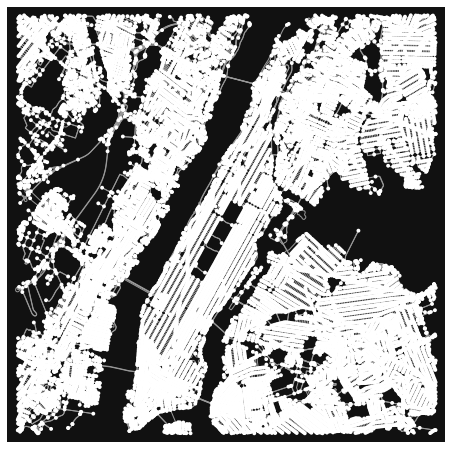

In [ ]:
ox.plot_graph(ny_graph, show=False, close=False)

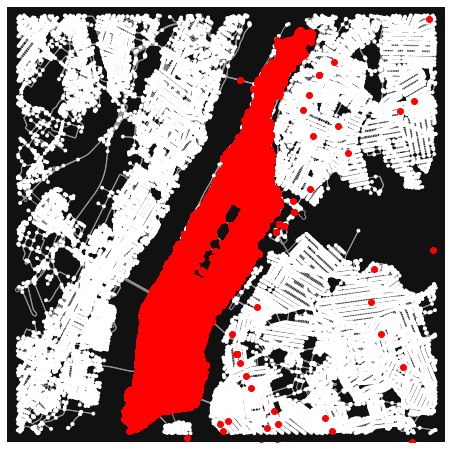

In [ ]:
fig, ax = ox.plot_graph(ny_graph, show=False, close=False)
add_accidents(ax, lng_ser=data_manhattan['LONGITUDE'], lat_ser=data_manhattan['LATITUDE'], clr='r')
plt.show()

## Создание датасета

### Обработаем данные так, чтобы их можно было связать между собой

In [ ]:
cars_manhattan = pd.read_csv('/content/cars_manhattan.csv', sep=';')

In [ ]:
data_manhattan.shape

(286635, 32)

In [ ]:
pd.to_datetime(data_manhattan['CRASH DATE'] + ' ' + data_manhattan['CRASH TIME'])

KeyboardInterrupt: ignored

In [ ]:
data_manhattan['CRASH DATE AND TIME'] = pd.to_datetime(data_manhattan['CRASH DATE'] + ' ' + data_manhattan['CRASH TIME'])

In [ ]:
data_manhattan.drop(columns=['CRASH DATE', 'CRASH TIME'], inplace=True)

In [ ]:
times = ['12:00-1:00 AM', '1:00-2:00AM', '2:00-3:00AM', '3:00-4:00AM', '4:00-5:00AM', '5:00-6:00AM', '6:00-7:00AM', '7:00-8:00AM', '8:00-9:00AM', '9:00-10:00AM', '10:00-11:00AM', '11:00-12:00PM', '12:00-1:00PM', '1:00-2:00PM', '2:00-3:00PM', '3:00-4:00PM', '4:00-5:00PM', '5:00-6:00PM', '6:00-7:00PM', '7:00-8:00PM', '8:00-9:00PM', '9:00-10:00PM', '10:00-11:00PM', '11:00-12:00AM']

In [ ]:
data_manhattan['time_period'] = data_manhattan['CRASH DATE AND TIME'].dt.hour.apply(lambda x: times[x])

In [ ]:
cars_cols = data_manhattan.columns[22:27]

In [ ]:
data_manhattan['Cars_count'] = (~data_manhattan[cars_cols].isna()).sum(axis=1)

In [ ]:
with open('cars_manhattan.csv', 'w') as f:
    f.write(';'.join(['date_time', 'car_type', 'car_voliation', 'lat', 'lon', 'point']) + '\n')
    for i in data_manhattan.index:
        dt = data_manhattan.loc[i, 'CRASH DATE AND TIME']
        lat = data_manhattan.loc[i, 'LATITUDE']
        lon = data_manhattan.loc[i, 'LONGITUDE']
        pnt = data_manhattan.loc[i, 'LOCATION']
        for j in range(data_manhattan.loc[i, 'Cars_count']):
            ct = data_manhattan.loc[i, f'VEHICLE TYPE CODE {j + 1}']
            cv = data_manhattan.loc[i, f'CONTRIBUTING FACTOR VEHICLE {j + 1}']
            f.write(';'.join([str(dt), str(ct), str(cv), str(lat), str(lon), str(pnt)]) + '\n')

In [ ]:
cars_manhattan.dropna(subset=['lon', 'lat'], inplace=True)

In [ ]:
def cast_to_float(st):
    return tuple(map(float, st.strip('()').split(', ')))

In [ ]:
cars_manhattan['point'] = cars_manhattan['point'].apply(lambda x: cast_to_float(x))

In [ ]:
cars_manhattan['date_time'] = pd.to_datetime(cars_manhattan['date_time'])

In [ ]:
def choose_period(t, times):
    return times[int(t)]

In [ ]:
cars_manhattan['month'] = cars_manhattan.date_time.dt.month
cars_manhattan['day_of_week'] = cars_manhattan.date_time.dt.dayofweek
cars_manhattan['time_period'] = cars_manhattan.date_time.apply(lambda x: choose_period(x.hour, times))

In [ ]:
# cars_lon = gpd.GeoSeries(cars_manhattan['lon'])
# cars_lat = gpd.GeoSeries(cars_manhattan['lat'])

In [ ]:
# cars_manhattan['edge'] = ox.nearest_edges(ny_graph, cars_lon, cars_lat)

(В следующий раз необходимо по авариям грани найти) 

In [ ]:
cars_manhattan['DATE'] = cars_manhattan['date_time'].dt.date

In [ ]:
cars_manhattan = cars_manhattan[cars_manhattan['date_time'].dt.year < 2021]

In [ ]:
data = cars_manhattan.merge(weather_manhattan, on='DATE', how='left')

In [ ]:
data.head()

In [ ]:
data.isna().sum()

Есть две аварии с неизвестными типами автомобилей, вставим самое частое значение из данной колонки

In [ ]:
data[data['car_type'].isna()]

In [ ]:
data['car_type'].value_counts()

In [ ]:
data['car_type'].fillna('PASSENGER VEHICLE', inplace=True)

In [ ]:
data['isaccident'] = (~data['car_type'].isna()).astype(int)

In [ ]:
data.columns

In [ ]:
data.drop(columns=['date_time', 'car_voliation', 'lat', 'lon', 'aid'], inplace=True)

In [ ]:
data.to_csv('accidents_data.csv')

In [ ]:
data = pd.read_csv('data_manhattan/accidents_data.csv')

In [ ]:
data['year'] = pd.to_datetime(data['DATE']).dt.year

Судя по данным, в них остаются ошибки

In [ ]:
list(x for x in data.car_type.unique() if 'schoo' in x or 'Schoo' in x or 'SCHOO' in x)

Обработаем типы машин с ошибками

In [ ]:
data.car_type = data.car_type.apply(lambda x: str.lower(x))

In [ ]:
to_replace = dict()
for t in data.car_type.unique():u
    a = input(f'Do you wanna replace _{t}_? ')
    if a != '':
        to_replace[t] = input(f'What the type it really is? ')

In [ ]:
data.replace(to_replace={'car_type': to_replace}, inplace=True)

In [ ]:
data.to_csv('accidents_data_2.csv')

In [ ]:
cars_manhattan = pd.read_csv('/content/cars_manhattan.csv', sep=';')

In [ ]:
data = pd.read_csv('data_manhattan/accidents_data_2.csv')

In [ ]:
data.shape

In [ ]:
cars_manhattan.dropna(subset=['lat'], inplace=True)

In [ ]:
cars_manhattan.shape

In [ ]:
data['edge'] = cars_manhattan.reset_index().loc[:, 'point']

In [ ]:
data['edge']

In [ ]:
data.to_csv('accidents_data_final.csv')

In [ ]:
weather_manhattan = pd.read_csv('/content/2601638.csv')

In [ ]:
weather = ['WT01', 'WT02', 'WT03', 'WT04', 'WT06', 'WT08', 'WT11', 'WT13', 'WT14', 'WT16', 'WT18', 'WT19', 'WT22']

In [ ]:
weather_manhattan['without_driver_troubles'] = (weather_manhattan[weather].isna().sum(axis=1) == len(weather)).astype(int)

In [ ]:
weather_manhattan.fillna(0, inplace=True)

In [ ]:
weather_manhattan.drop(columns=['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION'], inplace=True)

In [ ]:
weather_manhattan['DATE'] = pd.to_datetime(weather_manhattan['DATE']).dt.date

In [ ]:
weather_manhattan.head()

In [ ]:
weather_manhattan.to_csv('weather.csv')

## Работа с датасетом с авариями, созданным ранее

In [ ]:
os.environ['KAGGLE_USERNAME'] = "igorlukhnev"
os.environ['KAGGLE_KEY'] = "403bfdeb083a2fb5bb34353bb5fcb491"

In [ ]:
!kaggle datasets download -d igorlukhnev/manhattan-vehical-collisions-dataset

 73% 10.0M/13.8M [00:00<00:00, 34.2MB/s]
100% 13.8M/13.8M [00:00<00:00, 39.6MB/s]


In [ ]:
!mkdir data_manhattan & unzip manhattan-vehical-collisions-dataset.zip -d data_manhattan

Archive:  manhattan-vehical-collisions-dataset.zip
  inflating: data_manhattan/accidents_data.csv  mkdir: cannot create directory ‘data_manhattan’: File exists

  inflating: data_manhattan/accidents_data_2.csv  
  inflating: data_manhattan/weather.csv  


In [ ]:
weather_df = pd.read_csv('/content/data_manhattan/weather.csv')

In [ ]:
weather_df.drop(columns=['Unnamed: 0'], inplace=True)
weather_df['DATE'] = pd.to_datetime(weather_df['DATE']).dt.month

In [ ]:
def get_path_edges(path, city_graph):
    edges_list = []
    for i in range(len(path) - 1):
        node1 = path[i]
        node2 = path[i+1]
        for e in city_graph.edges:
            if node1 in e and node2 in e:
                edges_list.append(e)
                break
    return edges_list

In [ ]:
data.isna().sum()

Unnamed: 0                 0
Unnamed: 0.1               0
car_type                   0
month                      0
day_of_week                0
time_period                0
edge                       0
DATE                       0
AWND                       0
PGTM                       0
PRCP                       0
SNOW                       0
SNWD                       0
TAVG                       0
TMAX                       0
TMIN                       0
TSUN                       0
WDF2                       0
WDF5                       0
WSF2                       0
WSF5                       0
WT01                       0
WT02                       0
WT03                       0
WT04                       0
WT06                       0
WT08                       0
WT11                       0
WT13                       0
WT14                       0
WT16                       0
WT18                       0
WT19                       0
WT22                       0
without_driver

In [ ]:
data_ny_tv = pd.read_csv('/content/data_ny_tv.csv')

In [ ]:
data_ny_tv.head()

,Unnamed: 0,Segment ID,Roadway Name,From,To,Direction,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,3:00-4:00AM,4:00-5:00AM,5:00-6:00AM,6:00-7:00AM,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM,DayOfWeek
0,2,176365,"(42720018, 2024978445, 0)",Grand Concourse,Valentine Avenue,EB,2014-09-13,94.0,73.0,65.0,61.0,64.0,73.0,65.0,113.0,169.0,210.0,182.0,245.0,244,233,280,272,264,236,213,190,199,183,147,103,5
1,3,176365,"(42720018, 2024978445, 0)",Grand Concourse,Valentine Avenue,WB,2014-09-13,88.0,82.0,75.0,60.0,65.0,67.0,71.0,142.0,198.0,212.0,205.0,237.0,257,245,237,276,223,240,217,198,186,162,157,103,5
2,4,147673,"(42421745, 42428751, 0)",West 242 Street,240 Street,SB,2014-09-13,255.0,209.0,149.0,148.0,128.0,136.0,199.0,354.0,473.0,567.0,634.0,781.0,785,779,732,809,707,675,641,556,546,465,425,324,5
3,5,158447,"(42421745, 42428751, 0)",West 242 Street,240 Street,NB,2014-09-13,255.0,209.0,149.0,148.0,128.0,136.0,199.0,354.0,473.0,567.0,634.0,781.0,785,779,732,809,707,675,641,556,546,465,425,324,5
4,6,255653,"(42421745, 42428751, 0)",West 242 Street,240 Street,SB,2014-09-13,87.0,86.0,78.0,56.0,47.0,80.0,98.0,133.0,171.0,177.0,215.0,235.0,239,257,200,200,209,175,181,167,144,129,112,103,5


In [ ]:
data_ny_tv.rename({'Roadway Name': 'edge', 'DayOfWeek': 'day_of_week', 'Date': 'DATE'}, axis=1, inplace=True)

In [ ]:
data_ny_tv.drop(columns=['Unnamed: 0','Segment ID', 'From', 'To', 'Direction'], inplace=True)

Заполним пропуски

In [ ]:
nan_columns = data_ny_tv.columns[data_ny_tv.isna().sum() > 0]

In [ ]:
for c in nan_columns:
    data_ny_tv[c].fillna(data_ny_tv[c].median(), inplace=True)

In [ ]:
data_ny_tv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11648 entries, 0 to 11647
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   edge           11648 non-null  object 
 1   DATE           11648 non-null  object 
 2   12:00-1:00 AM  11648 non-null  float64
 3   1:00-2:00AM    11648 non-null  float64
 4   2:00-3:00AM    11648 non-null  float64
 5   3:00-4:00AM    11648 non-null  float64
 6   4:00-5:00AM    11648 non-null  float64
 7   5:00-6:00AM    11648 non-null  float64
 8   6:00-7:00AM    11648 non-null  float64
 9   7:00-8:00AM    11648 non-null  float64
 10  8:00-9:00AM    11648 non-null  float64
 11  9:00-10:00AM   11648 non-null  float64
 12  10:00-11:00AM  11648 non-null  float64
 13  11:00-12:00PM  11648 non-null  float64
 14  12:00-1:00PM   11648 non-null  int64  
 15  1:00-2:00PM    11648 non-null  int64  
 16  2:00-3:00PM    11648 non-null  int64  
 17  3:00-4:00PM    11648 non-null  int64  
 18  4:00-5

In [ ]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'car_type', 'month', 'day_of_week',
       'time_period', 'edge', 'DATE', 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD',
       'TAVG', 'TMAX', 'TMIN', 'TSUN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01',
       'WT02', 'WT03', 'WT04', 'WT06', 'WT08', 'WT11', 'WT13', 'WT14', 'WT16',
       'WT18', 'WT19', 'WT22', 'without_driver_troubles', 'isaccident',
       'year'],
      dtype='object')

In [ ]:
data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'year', 'DATE'], inplace=True)

In [ ]:
data_ny_tv['month'] = pd.to_datetime(data_ny_tv['DATE']).dt.month

In [ ]:
weather_df.rename({'DATE': 'month'}, axis=1, inplace=True)

In [ ]:
data.head()

,car_type,month,day_of_week,time_period,edge,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT11,WT13,WT14,WT16,WT18,WT19,WT22,without_driver_troubles,isaccident
0,sedan,4,4,1:00-2:00AM,"(40.77161, -73.99046)",5.37,0.0,0.07,0.0,0.0,0.0,51,36,0.0,220.0,220.0,14.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,station wagon/sport utility vehicle,12,3,12:00-1:00PM,"(40.7602, -73.996864)",5.14,0.0,0.48,0.0,0.0,0.0,48,36,0.0,300.0,300.0,15.0,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,box truck,12,3,12:00-1:00PM,"(40.7602, -73.996864)",5.14,0.0,0.48,0.0,0.0,0.0,48,36,0.0,300.0,300.0,15.0,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,van,5,6,12:00-1:00 AM,"(40.84103, -73.94463)",7.38,0.0,0.00,0.0,0.0,0.0,64,39,0.0,250.0,230.0,18.1,29.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,sedan,5,6,12:00-1:00 AM,"(40.84103, -73.94463)",7.38,0.0,0.00,0.0,0.0,0.0,64,39,0.0,250.0,230.0,18.1,29.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [ ]:
data.car_type = copy_car_types = data.loc[:, 'car_type']

In [ ]:
data.car_type.replace(to_replace={'pick-up truck': 'truck', 
                                  'box truck': 'truck', 
                                  'dump truck': 'big truck',
                                  'pick up truck': 'truck',
                                  'tractor truck diesel': 'big truck',
                                  'flat bed': 'big truck',
                                  'tractor truck gasoline': 'big truck',
                                  'moped': 'motorcycle',
                                  'tanker': 'big truck',
                                  'beverage truck': 'truck',
                                  'chassis cab': 'truck',
                                  'lift bloom': 'lift boom',
                                  'bicycle': 'bike',
                                  'track': 'truck',
                                  'cadet': 'sedan',
                                  'pallet': 'carry all tractor',
                                  'motorbike': 'motorcycle'}, inplace=True)

In [ ]:
vt_ny = pd.read_csv("/content/Vehicle_Makes_and_Body_Types__Most_Popular_in_New_York_State.csv")

In [ ]:
vt_ny.shape

(42721, 4)

In [ ]:
vt_ny['Body Type'].unique()

array(['SUBN', '4DSD', 'PICK', 'MCY', 'VAN', '2DSD', 'LTRL', 'SNOW',
       'ATV', 'CONV', 'BOAT', 'DUMP', 'UTIL', 'BUS', 'TRLR', 'TRAC',
       'MOPD', 'SEMI', 'DELV', 'FLAT', 'TAXI', 'STAK', 'H/TR', 'P/SH',
       'H/WH', 'REFG', 'TANK', 'TOW', 'SEDN', 'AMBU', 'RBM', 'CMIX',
       'HRSE', 'LSV', 'S/SP', 'RD/S', 'TR/C', 'LIM', 'FIRE', 'SN/P',
       'EMVR', 'W/DR', 'T/CR', 'DCOM', 'SWT', 'W/SR', 'CUST', '????',
       'R/RD', 'FPM', 'LSVT', 'MCC', 'H/IN', 'TR/E', 'POLE', 'LOCO',
       'RPLC', 'TRAV', 'MFH'], dtype=object)

In [ ]:
to_replace={'SUBN': 'station wagon/sport utility vehicle', 
            '4DSD': 'sedan', 
            'PICK': 'truck', 
            'MCY': 'motorcycle', 
            'VAN': 'van',
            '2DSD': '3-door', 
            'LTRL': 'trailer', 
            'SNOW': 'snow plow',
            'ATV': 'multi-wheeled vehicle', 
            'CONV': 'convertible',
            'DUMP': 'big truck', 
            'UTIL': 'station wagon/sport utility vehicle', 
            'BUS': 'bus', 
            'TRLR': 'trailer', 
            'TRAC': 'tractor', 
            'MOPD': 'motorcycle', 
            'SEMI': 'trailer', 
            'DELV': 'truck', 
            'FLAT': 'big truck', 
            'TAXI': 'taxi', 
            'STAK': 'big truck', 
            'H/TR': 'trailer', 
            'P/SH': 'power shovel', 
            'H/WH': 'trailer', 
            'REFG': 'van', 
            'TANK': 'big truck', 
            'TOW': 'tow truck / wrecker', 
            'SEDN': 'sedan', 
            'AMBU': 'van', 
            'RBM': 'snow plow', 
            'CMIX': 'snow plow', 
            'HRSE': 'van', 
            'LSV': '3-door', 
            'S/SP': 'tractor', 
            'RD/S': 'snow plow', 
            'TR/C': 'lift boom', 
            'LIM': 'limousine', 
            'FIRE': 'fire', 
            'SN/P': 'snow plow', 
            'EMVR': 'power shovel', 
            'W/DR': 'snow plow', 
            'T/CR': 'lift boom', 
            'DCOM': 'van', 
            'SWT': 'truck', 
            'W/SR': 'lift boom', 
            'CUST': 'sedan', 
            '????': 'unknown', 
            'R/RD': 'tractor', 
            'FPM': 'snow plow', 
            'LSVT': 'truck', 
            'MCC': 'big truck', 
            'H/IN': 'van', 
            'TR/E': 'tractor', 
            'POLE': 'big truck', 
            'LOCO': 'locomotive',
            'RPLC': '3-door', 
            'TRAV': 'multi-wheeled vehicle', 
            'MFH': 'trailer'}

In [ ]:
vt_ny['Body Type'].replace(to_replace=to_replace, inplace=True)

In [ ]:
vt_ny.drop(vt_ny[(vt_ny['Body Type'] == 'locomotive') | (vt_ny['Body Type'] == 'BOAT')].index, axis=0, inplace=True)

In [ ]:
vt_ny.groupby('Body Type').sum('Registration Class').index
vt_ny.groupby('Body Type').sum('Registration Class')['Registration Class']

Body Type
3-door                                  408044
big truck                               123903
bus                                      58143
convertible                             173105
fire                                      1050
lift boom                                 3300
limousine                                  532
motorcycle                              311669
multi-wheeled vehicle                   115945
power shovel                             10326
sedan                                  3216279
snow plow                               124823
station wagon/sport utility vehicle    5329209
taxi                                      5585
tow truck / wrecker                       6650
tractor                                  38535
trailer                                 749149
truck                                  1276180
unknown                                    267
van                                     238022
Name: Registration Class, dtype: int64

In [ ]:
data['car_type'].unique()

array(['sedan', 'station wagon/sport utility vehicle', 'truck', 'van',
       'bus', 'motorcycle', 'taxi', 'bike', 'e-scooter',
       'tow truck / wrecker', 'big truck', 'carry all tractor',
       'convertible', 'garbage truck', 'fire', 'unknown', 'e-bike',
       'skywatch', 'snow plow', 'concrete mixer', 'limousine', 'pedicub',
       'stake or rack', 'lift boom', 'armored truck', '3-door',
       'police truck', 'scooter', 'power shovel', 'multi-wheeled vehicle',
       'skateboard', 'horse', 'trailer', 'cross', 'tractor'], dtype=object)

## Анализ данных

In [ ]:
m_i = ['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']
d_i = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']

<AxesSubplot:>

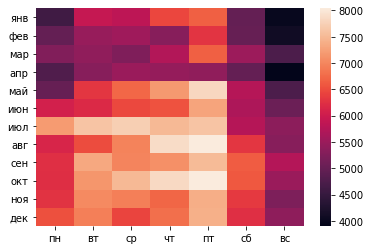

In [ ]:
data_monthes = data['month'].unique()
data_monthes.sort()
data_days_of_week = data['day_of_week'].unique()
data_days_of_week.sort()
data_list = []
for m in data_monthes:
    rows = []
    for d in data_days_of_week:
        rows.append(data[(data['month'] == m) & (data['day_of_week'] == d)]['car_type'].count())
    data_list.append(rows)
sns.heatmap(pd.DataFrame(data_list, index=m_i, columns=d_i))

Судя по графику, больше всего аварий случается по пятницам, меньше всего - по воскресениям. В целом, сезон аварий начинается с мая и заканчивается в декабре. По будням всегда аварий больше, чем по выходным. Проанализируем также поток.

<AxesSubplot:>

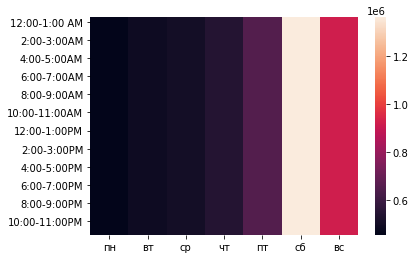

In [ ]:
for t in times:
    rows = []
    for d in data_days_of_week:
        rows.append(data_ny_tv[data_ny_tv['day_of_week'] == d][t].sum())
sns.heatmap(pd.DataFrame([rows], columns=d_i, index=times))

Как мы видим, в будние в целом меньше трафик, чем в выходные, при этом в будние больше аварий. Можно сделать вывод о том, что день недели может сильно повлиять на вероятность аварии.

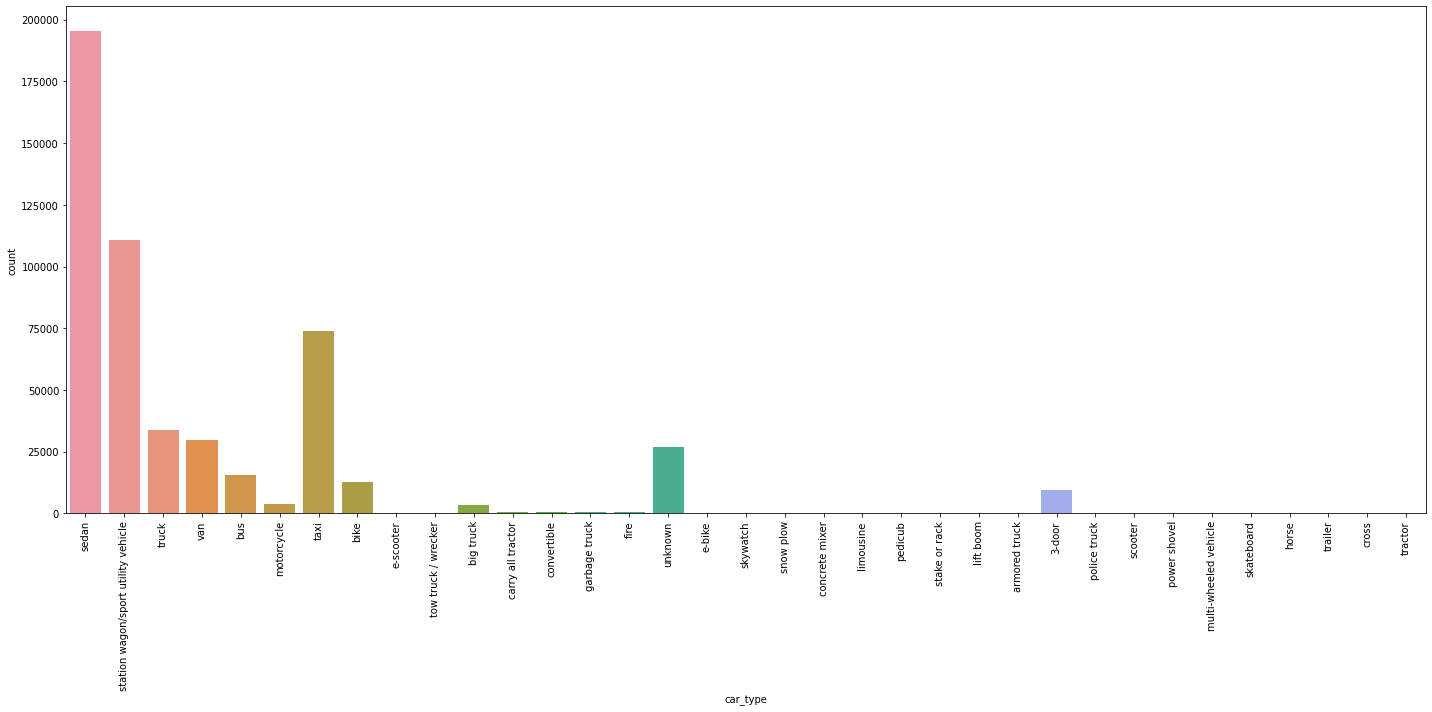

In [ ]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
sns.countplot(data=data, x='car_type')
plt.tight_layout()

Больше всего аварий происходит с седанами, грузовиками и такси. Что в целом неудивительно.

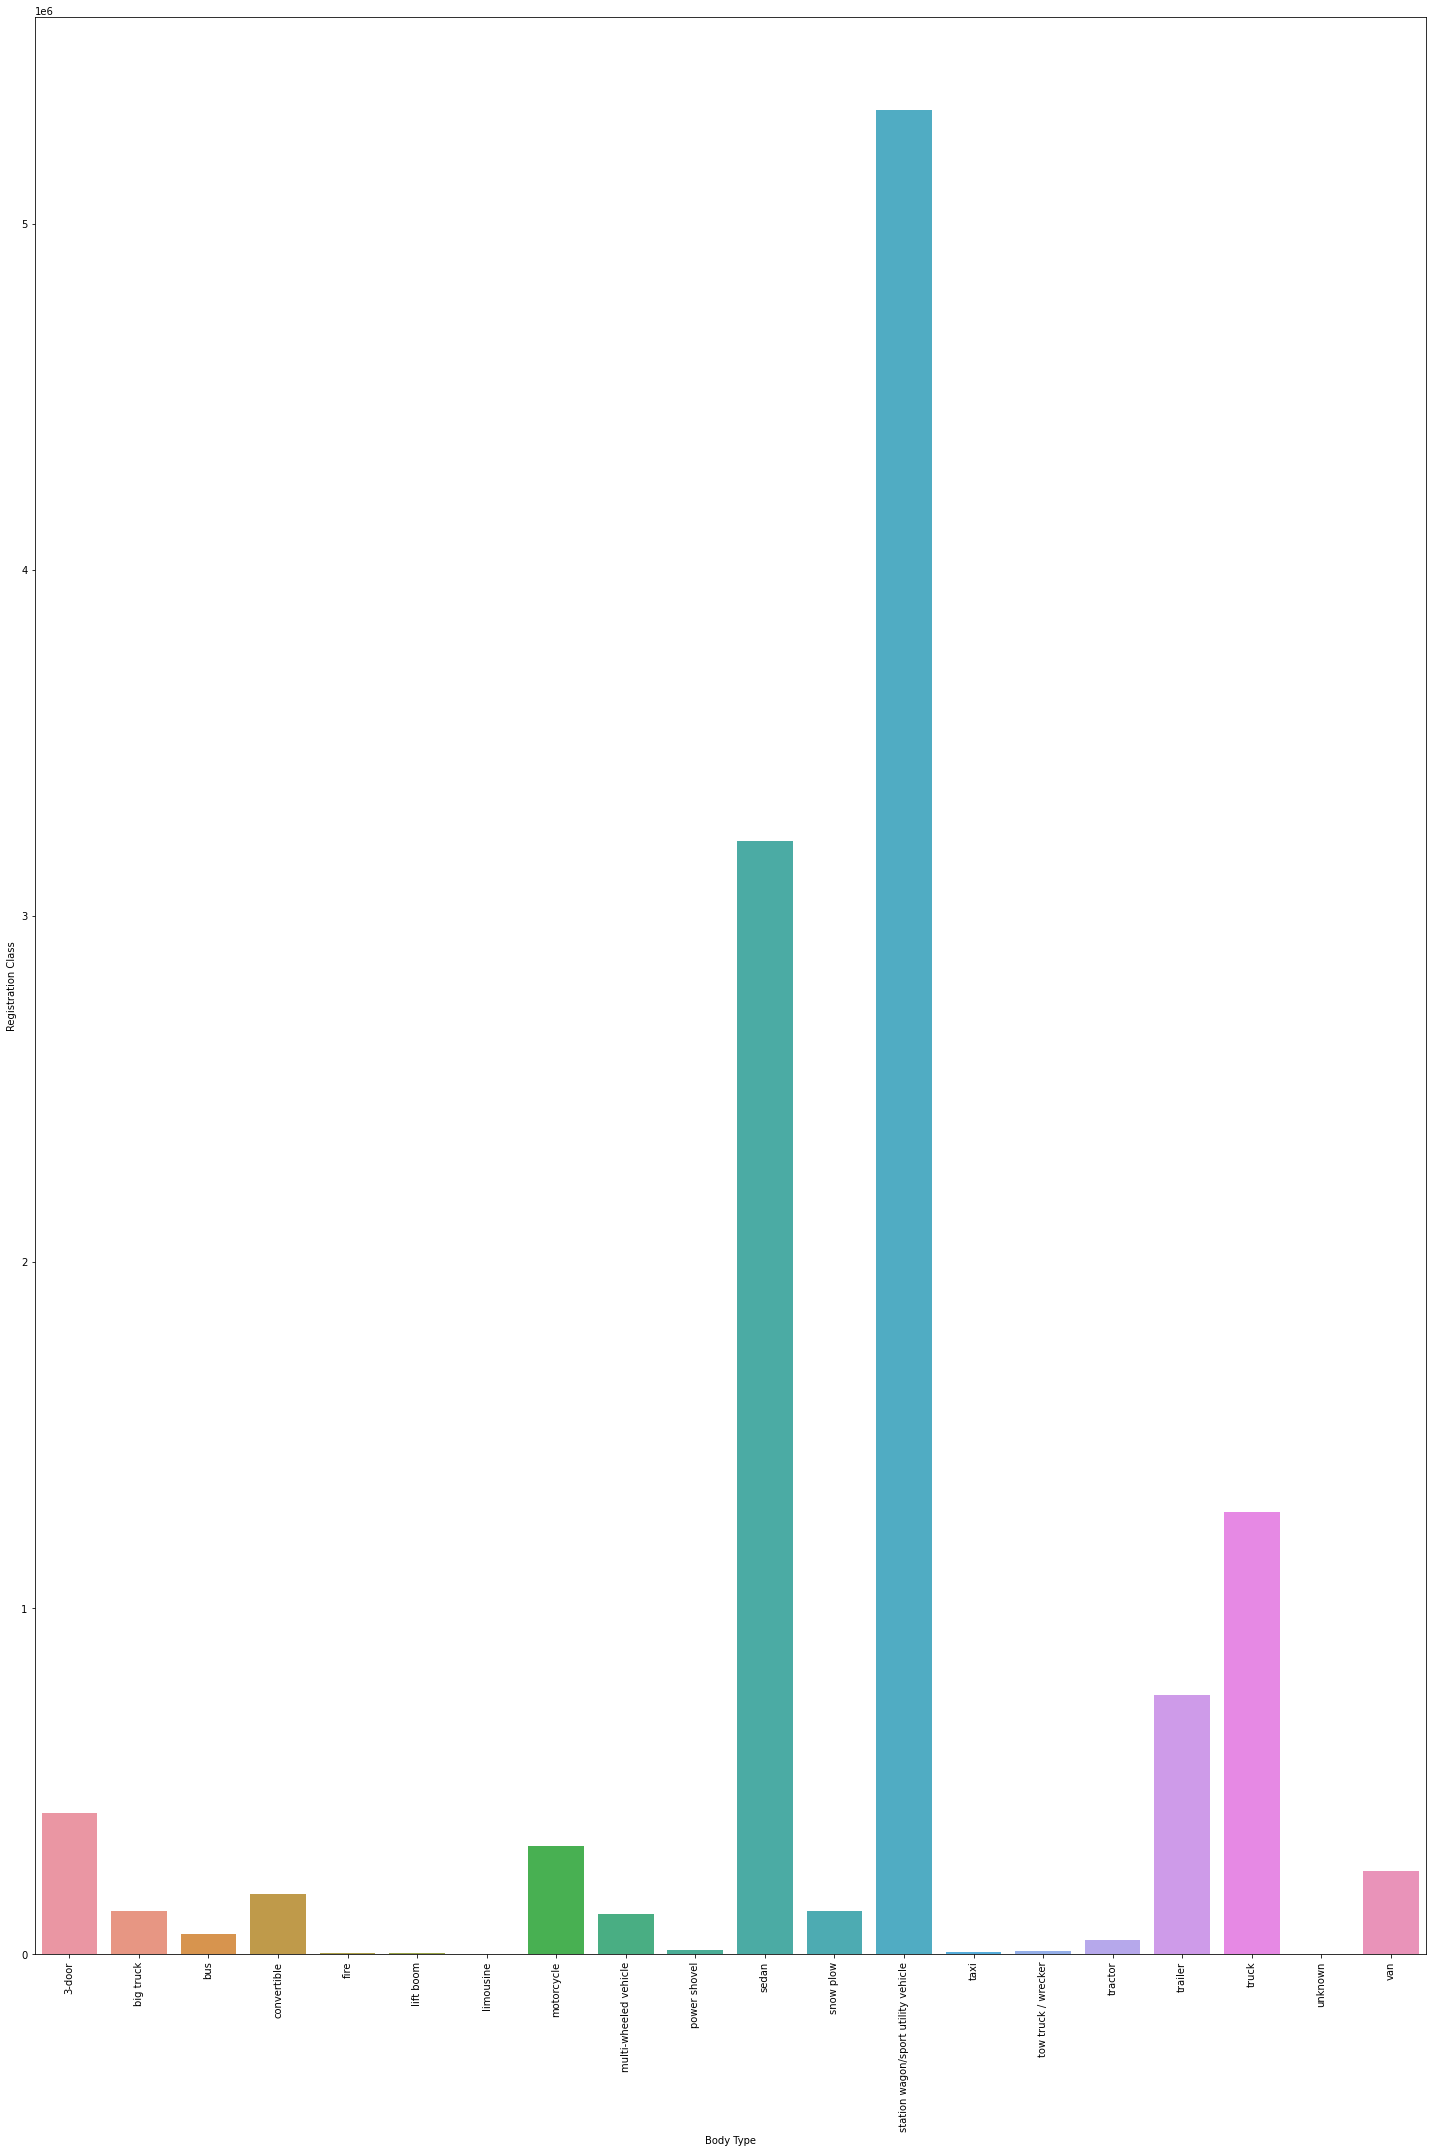

In [ ]:
plt.figure(figsize=(20, 30))
plt.xticks(rotation=90)
sns.barplot(x=vt_ny.groupby('Body Type').sum('Registration Class').index, y=vt_ny.groupby('Body Type').sum('Registration Class')['Registration Class'])
plt.tight_layout()

Рассмотрим теперь влияние погодных условий на число аварий

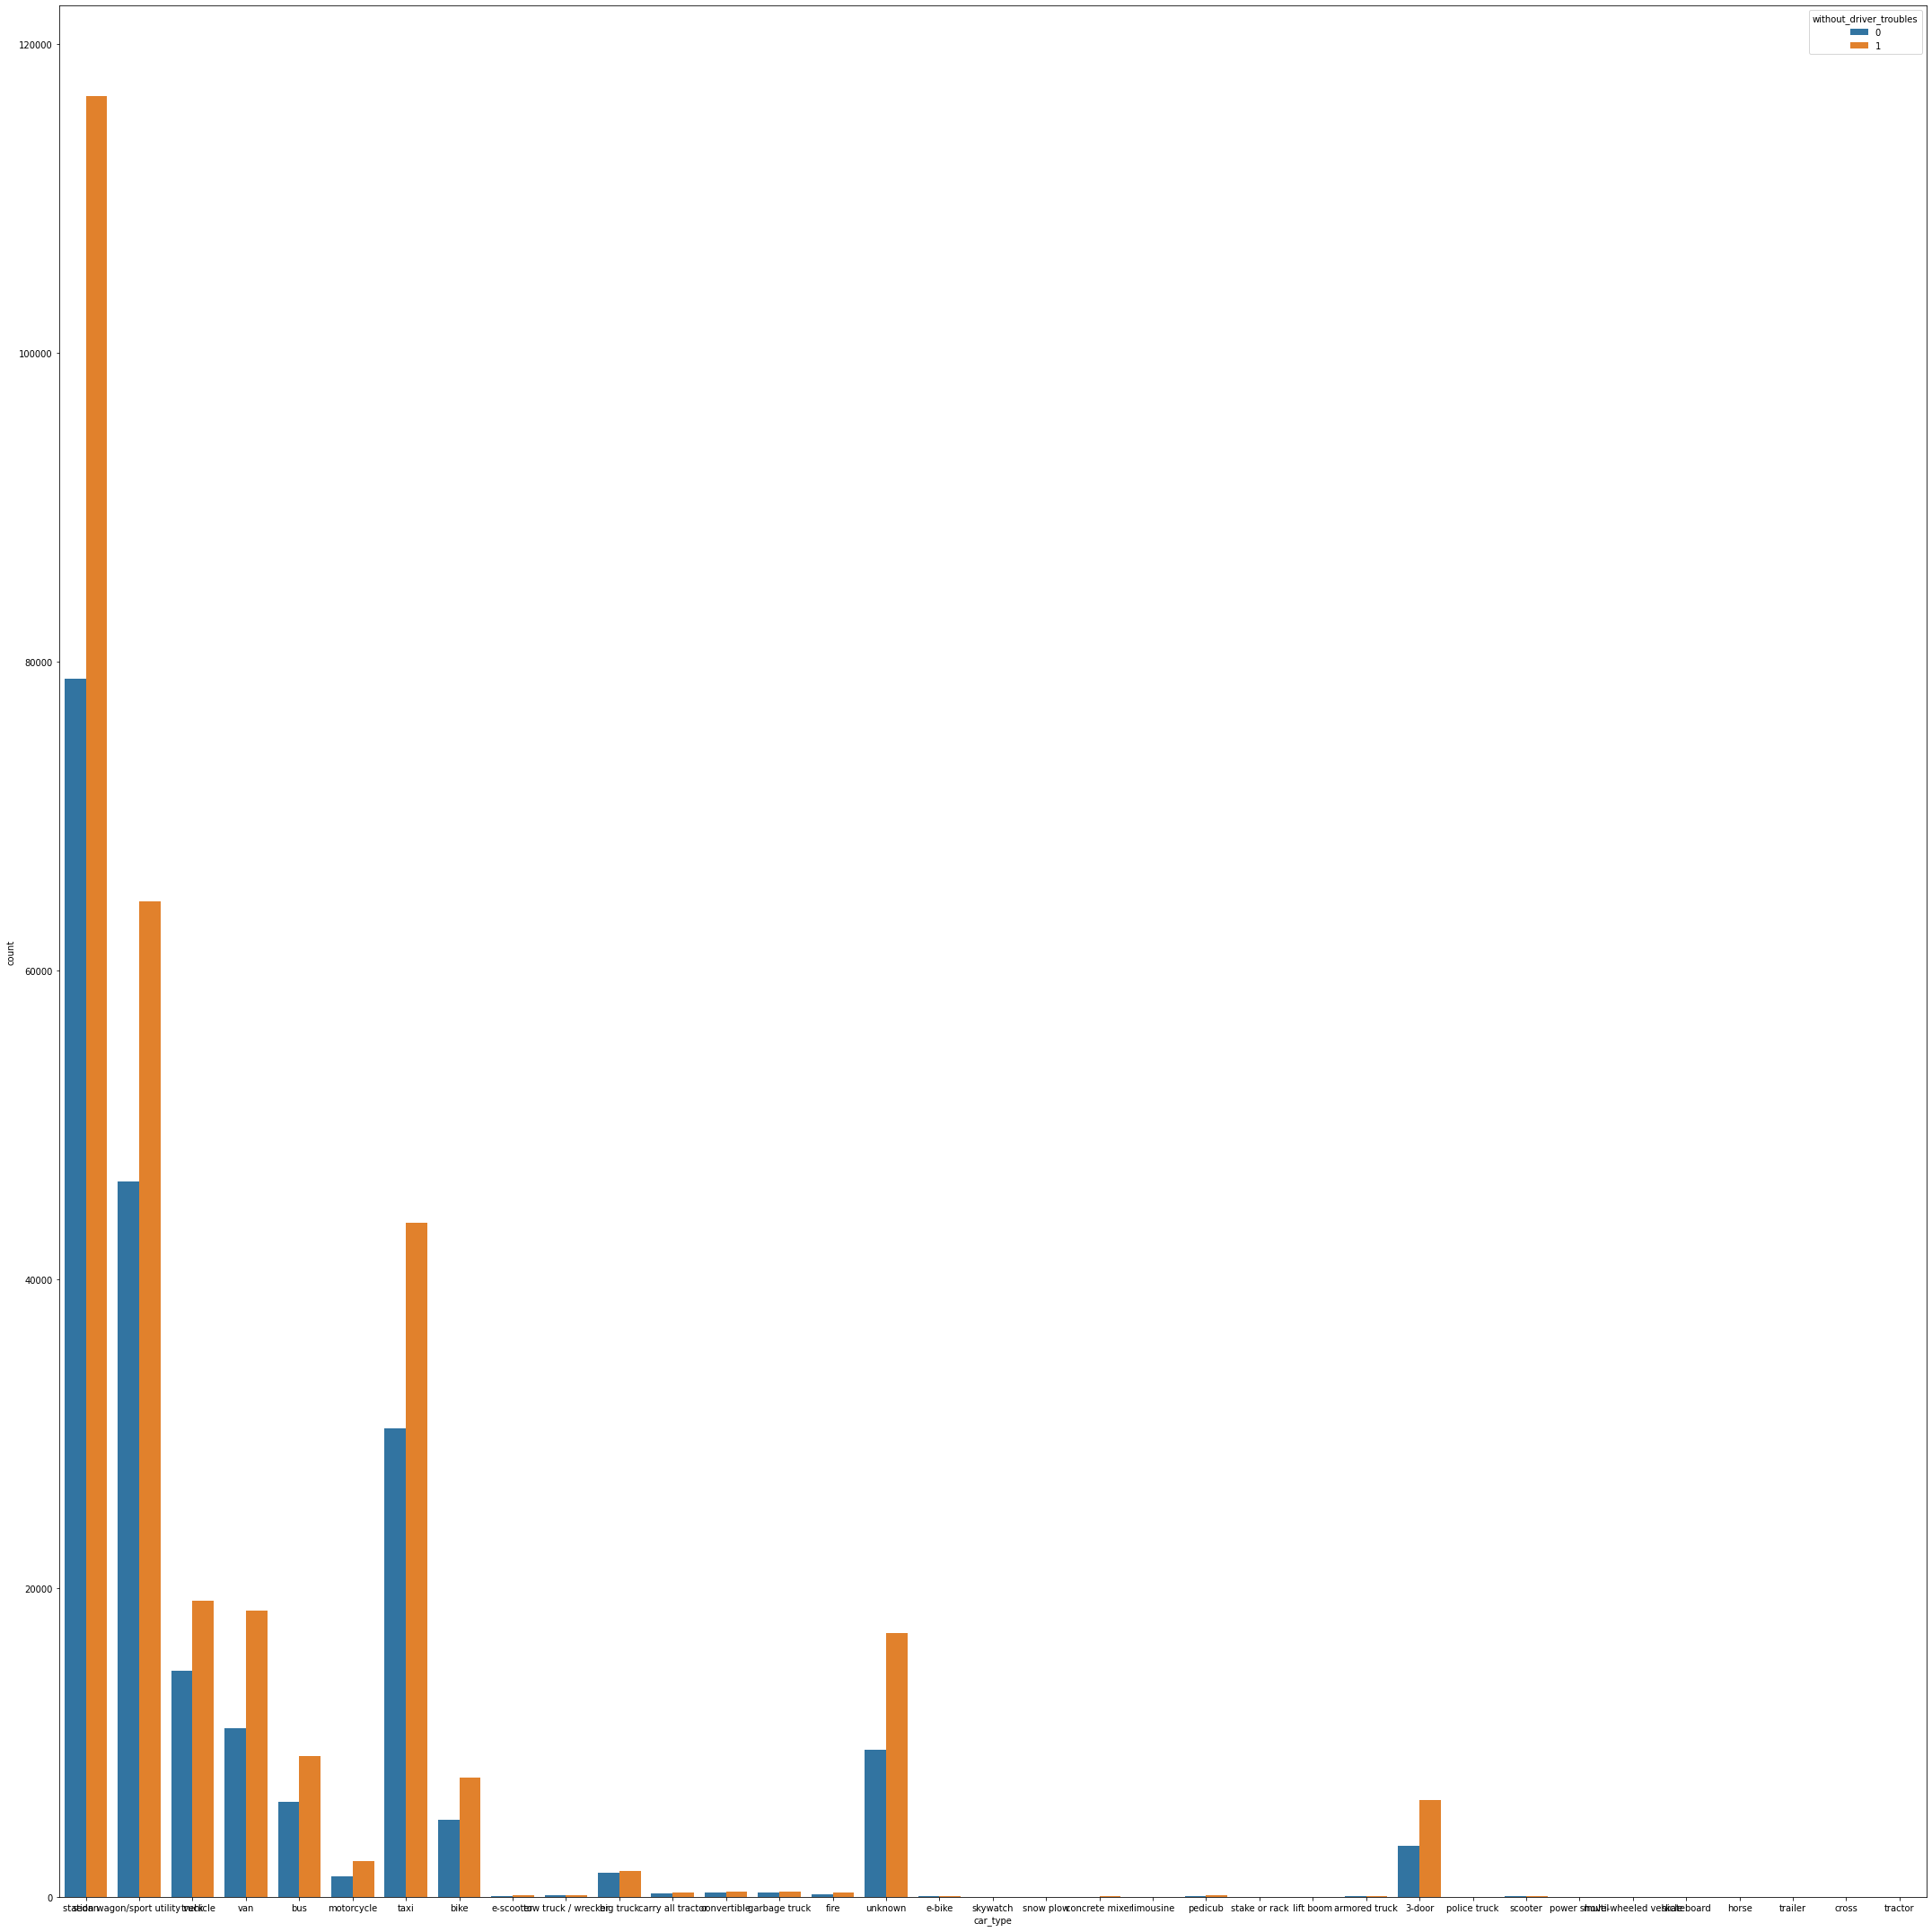

In [ ]:
plt.figure(figsize=(30, 30))
sns.countplot(data=data.replace({''}), x='car_type', hue='without_driver_troubles')
plt.tight_layout()

<AxesSubplot:xlabel='without_driver_troubles', ylabel='count'>

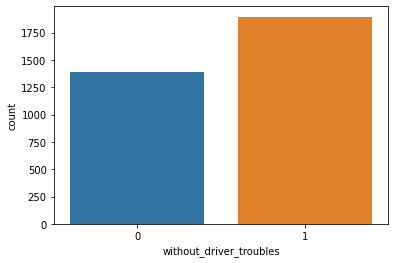

In [ ]:
sns.countplot(data=weather_df, x='without_driver_troubles')

Похоже, что в хорошую погоду случается больше аварий, вероятно, из-за большего размера трафика.

Построим теперь график аварий в зависимости от погоды

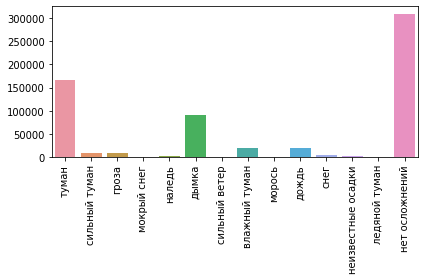

In [ ]:
y = []
x = ['туман', 'сильный туман', 'гроза', 'мокрый снег', 'наледь', 'дымка', 'сильный ветер', 'влажный туман', 'морось', 'дождь', 'снег', 'неизвестные осадки', 'ледяной туман', 'нет осложнений']
for c in WEATHER[13:]:
    y.append(len(data[data[c] != 0]))
plt.xticks(rotation=90)
sns.barplot(x=x, y=y)
plt.tight_layout()

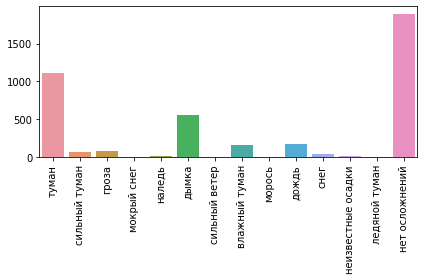

In [ ]:
y = []
for c in WEATHER[13:]:
    y.append(len(weather_df[weather_df[c] != 0]))
plt.xticks(rotation=90)
sns.barplot(x=x, y=y)
plt.tight_layout()

## Разработка основной логики

Объявим глобальные переменные

In [ ]:
TYPE = 'car_type'
VT = 'Body Type'
AMOUNT = 'Registration Class'
MONTH = 'month'
DOW = 'day_of_week'
TP = 'time_period'
EDGE = 'edge'
TARGET = 'isaccident'
OR = 'origin'
DEST = 'destination'
MONTHS = 'months'
DOWS = 'days_of_week'
TPS = 'time_periods'
GW = 'without_driver_troubles'
WEATHER = ['AWND', 'PGTM',	'PRCP',	'SNOW',	'SNWD',	'TAVG',	'TMAX',	'TMIN',	'TSUN',	'WDF2',	'WDF5',	'WSF2',	'WSF5',	'WT01',	'WT02',	'WT03',	'WT04',	'WT06',	'WT08',	'WT11',	'WT13',	'WT14',	'WT16',	'WT18',	'WT19',	'WT22',	'without_driver_troubles']
TIMES = ['12:00-1:00 AM', '1:00-2:00AM', '2:00-3:00AM', '3:00-4:00AM', '4:00-5:00AM', '5:00-6:00AM', '6:00-7:00AM', '7:00-8:00AM', '8:00-9:00AM', '9:00-10:00AM', '10:00-11:00AM', '11:00-12:00PM', '12:00-1:00PM', '1:00-2:00PM', '2:00-3:00PM', '3:00-4:00PM', '4:00-5:00PM', '5:00-6:00PM', '6:00-7:00PM', '7:00-8:00PM', '8:00-9:00PM', '9:00-10:00PM', '10:00-11:00PM', '11:00-12:00AM']
LON = 'LONGITUDE'
LAT = 'LATITUDE'
CD = ['car_type', 'month', 'day_of_week', 'time_period']

In [ ]:
def save_df_as_image(df, path):
    source = ColumnDataSource(df)
    df_columns = [df.index.name]
    df_columns.extend(df.columns.values)
    columns_for_table=[]
    for column in df_columns:
        columns_for_table.append(TableColumn(field=column, title=column))

    data_table = DataTable(source=source, columns=columns_for_table,height_policy="auto",width_policy="auto",index_position=None)
    export_png(data_table, filename = path)

In [ ]:
def create_path(route_start, route_end, city_graph):
    start_node = ox.nearest_nodes(city_graph, route_start[1], route_start[0])
    end_node = ox.nearest_nodes(city_graph, route_end[1], route_end[0])
    # Calculate the shortest path
    route = nx.shortest_path(city_graph, start_node, end_node, weight='travel_time')
    return route

In [ ]:
def add_accidents(ax, lng_ser, lat_ser, clr):
    ax.scatter(lng_ser, lat_ser, c=clr)

In [ ]:
def get_path_edges(path, city_graph):
    edges_list = []
    for i in range(len(path) - 1):
        node1 = path[i]
        node2 = path[i+1]
        for e in city_graph.edges:
            if node1 in e and node2 in e:
                edges_list.append(e)
                break
    return edges_list

In [ ]:
def cast_to_float(st):
    return tuple(map(float, st.strip('()').split(', ')))

In [ ]:
class User:
    def __init__(self, name, car_type, marchroutes):
        self.car_type = car_type
        self.name = name
        self.marchroutes = marchroutes
        self.proba = 0

    def add_marchroute(self, name, origin, destination, monthes, days_of_week, time_periods, is_backward=False, back_periods=None):
        self.marchroutes[name] = {OR: origin, DEST: destination, MONTHS: monthes, DOWS: days_of_week, TPS: time_periods}
        if is_backward:
            self.marchroutes[f'{name}_back'] = {OR: origin, DEST: destination, MONTHS: monthes, DOWS: days_of_week, TPS: back_periods}

    def set_proba(self, proba, n):
        self.proba = -np.log(1 - proba) / n

    def get_proba(self):
        return self.proba

    def get_one_trip_proba(self):
        self.cnt_trips = 0
        for m in self.marchroutes:
            self.cnt_trips += len(self.marchroutes[m][MONTHS])*len(self.marchroutes[m][DOWS])*len(self.marchroutes[m][TPS]*4
        return self.proba/self.cnt_trips

In [ ]:
class ProbaPredictor:
    def __init__(self, city_graph, positive, weather_df, aadt, raw_data, car_popularity):
        self.positive = positive
        self.weather_df = weather_df
        self.clf = catboost.CatBoostClassifier(n_estimators=3000, use_best_model=True)
        self.aadt = aadt
        self.city_graph = city_graph
        self.raw_data = raw_data
        self.car_popularity = car_popularity.groupby(VT).sum(AMOUNT)
        self.model_quality = ''
        np.random.seed(123)

    def generate_negative(self, month, day_of_week, time_period, aadt, edge):
        sample = []
        p = (self.car_popularity/self.car_popularity.sum())
        a = self.car_popularity.index
        aadt = 36*int(round(aadt, 0))
        gwp = self.weather_df[self.weather_df[MONTH] == month][GW].sum()/self.weather_df[self.weather_df[MONTH] == month][GW].shape[0]
        gwaadt = int(gwp*aadt)
        bwaadt = aadt - gwaadt
        weather_good_id = np.random.choice(np.array(self.weather_df[(self.weather_df[MONTH] == month) & (self.weather_df[GW] == 1)].index), size=int(gwaadt), replace=True)
        weather_bad_id = np.random.choice(np.array(self.weather_df[(self.weather_df[MONTH] == month) & (self.weather_df[GW] == 0)].index), size=int(bwaadt), replace=True)
        weather_id = np.concatenate((weather_good_id, weather_bad_id))
        # line = self.city_graph.edges[edge]['geometry']
        for i in range(aadt):
            car_type = np.random.choice(a, size=1, p=p[AMOUNT])[0]
            # edge = self.generate_random_point(line.coords[0], line.coords[1])
            sample.append([car_type, month, day_of_week, time_period, edge])
        sample = pd.DataFrame(sample, columns=[TYPE, MONTH, DOW, TP, EDGE])
        sample = pd.concat((sample, self.weather_df.loc[weather_id, WEATHER].set_index(sample.index)), axis=1)
        sample[TARGET] = (sample[TYPE].isna()).astype(int)
        self.negative = sample

    def generate_random_point(self, point1, point2):
        a = (point2[1] - point1[1])/(point2[0] - point1[0])
        b = point1[1] - a*point1[0]
        x = random.uniform(point1[0], point2[0])
        y = a*x + b
        return (x, y)

    def process_user(self, user, to_plot=False, print_result=False):
        proba_list = []
        drives = 0
        proba_m = []
        for m in user.marchroutes:
            cnt_drives = len(user.marchroutes[m][MONTHS])*len(user.marchroutes[m][DOWS])*len(user.marchroutes[m][TPS])
            drives += cnt_drives
            proba_m.append(cnt_drives)
            proba = self.process_marchroute(user.marchroutes[m], user.car_type, to_plot)
            if print_result:
                print(f'For {user.name} on route {m} proba is: {proba}')
            proba_list.append(proba)
        return (np.array(proba_list)*np.array(proba_m)/drives).sum()
    
    def process_marchroute(self, marchroute, car_type, to_plot):
        proba = 0
        path = create_path(marchroute[OR], marchroute[DEST], self.city_graph)
        path_edges = get_path_edges(path, self.city_graph)
        if to_plot:
            self.plot_graph(path, marchroute[MONTHS], marchroute[DOWS], marchroute[TPS])
        proba_month = []
        for month in marchroute[MONTHS]:
            proba_day = []
            for day in marchroute[DOWS]:
                for period in marchroute[TPS]:
                    proba_route = [0]
                    for e in path_edges:
                        aadt = self.aadt[(self.aadt[EDGE] == e) & (self.aadt[MONTH] == month) & (self.aadt[DOW] == day)][period].mean()
                        if aadt is np.nan:
                            aadt = self.aadt[(self.aadt[MONTH] == month) & (self.aadt[DOW] == day)][period].mean()
                            if aadt is np.nan:
                                aadt = self.aadt[self.aadt[DOW] == day][period].mean()
                        self.generate_negative(month, day, period, aadt,  e)
                        X_p = self.positive[(self.positive[MONTH] == month) & (self.positive[DOW] == day) & (self.positive[TP] == period)]
                        if 'geometry' in self.city_graph.edges[e]:
                            X_p = X_p[X_p[EDGE].apply(lambda x: self.city_graph.edges[e]['geometry'].distance(Point(x)) <= 250)]
                            if X_p.shape[0] == 0:
                                proba_route.append(0)
                            else:
                                X = pd.concat([X_p, self.negative])
                                X.sample(frac=1)
                                X.reset_index(inplace=True)
                                X.drop(columns=[EDGE], inplace=True)
                                y = X[TARGET]
                                X.drop([TARGET, 'index'], axis=1, inplace=True)
                                proba_route.append((1-sum(proba_route))*self.predict_proba(X, y, car_type, month, day, period, e))
                proba_day.append(sum(proba_route))
            proba_month.append(sum(proba_day)/len(proba_day))
        proba = sum(proba_month)/len(proba_month)
        return proba

    def predict_proba(self, X, y, car_type, month, day, period, edge):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17, test_size=0.05)
        self.clf.fit(X_train, y_train, cat_features=[0, 3], eval_set=(X_test, y_test), silent=True)
        weather_id_good = random.choice(self.weather_df[(self.weather_df[MONTH] == month) & (self.weather_df[GW].astype(bool))].index)
        weather_id_bad = random.choice(self.weather_df[(self.weather_df[MONTH] == month) & (~self.weather_df[GW].astype(bool))].index)
        good_weather_proba = self.weather_df[self.weather_df[MONTH] == month][GW].mean()
        user_sample = pd.DataFrame([[car_type, month, day, period]], columns=CD)
        user_sample_good = pd.concat([user_sample, self.weather_df.loc[weather_id_good, WEATHER].to_frame().transpose().set_index(user_sample.index)], axis=1)
        user_sample_bad = pd.concat([user_sample, self.weather_df.loc[weather_id_bad, WEATHER].to_frame().transpose().set_index(user_sample.index)], axis=1)
        self.save_clf_quality(X_test, y_test)
        # Посчитаем полную вероятность для клиента в случае разных погодных условий
        proba = good_weather_proba * self.clf.predict_proba(user_sample_good) + (1 - good_weather_proba) * self.clf.predict_proba(user_sample_bad)
        return proba[0, 1]

    def plot_graph(self, path, months, days_of_week, time_periods):
        fig, ax = ox.plot_graph_route(self.city_graph, path, route_linewidth=3, route_color='b', node_size=0, bgcolor='k', show=False, close=False)
        self.raw_data[MONTH] = pd.to_datetime(self.raw_data['CRASH DATE']).dt.month
        self.raw_data[DOW] = pd.to_datetime(self.raw_data['CRASH DATE']).dt.dayofweek
        self.raw_data[TP] = pd.to_datetime(self.raw_data['CRASH TIME']).dt.hour.apply(lambda x: TIMES[x])
        for m in months:
            for d in days_of_week:
                for t in time_periods:
                    accidents = self.raw_data[(self.raw_data[MONTH] == m) & (self.raw_data[DOW] == d) & (self.raw_data[TP] == t)]
                    add_accidents(ax, accidents[LON], accidents[LAT], clr='r')

    def save_clf_quality(self, X_test, y_test):
        min_accuracy = y_test.sum()/y_test.shape[0]
        y_pred = self.clf.predict(X_test)
        s1 = f'Min expected accuracy: {1 - min_accuracy} - Model result is {accuracy_score(y_test, y_pred)}\nModel predicts crash for {1 - precision_score(y_test, y_pred, zero_division=0)} cars without crashes\nModel found {recall_score(y_test, y_pred)} crashes'
        s2 = f'Best model iteration is: {self.clf.get_best_iteration()}\n'
        self.model_quality += '\n'.join([s1, s2])
    
    def get_clf_quality(self):
        return self.model_quality

## Тестирование

In [ ]:
data.car_type.unique()

array(['sedan', 'station wagon/sport utility vehicle', 'truck', 'van',
       'bus', 'motorcycle', 'taxi', 'bike', 'e-scooter',
       'tow truck / wrecker', 'big truck', 'carry all tractor',
       'convertible', 'garbage truck', 'fire', 'unknown', 'e-bike',
       'skywatch', 'snow plow', 'concrete mixer', 'limousine', 'pedicub',
       'stake or rack', 'lift boom', 'armored truck', '3-door',
       'police truck', 'scooter', 'power shovel', 'multi-wheeled vehicle',
       'skateboard', 'horse', 'trailer', 'cross', 'tractor'], dtype=object)

In [ ]:
data.columns

Index(['car_type', 'month', 'day_of_week', 'time_period', 'edge', 'AWND',
       'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TSUN', 'WDF2',
       'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT06', 'WT08',
       'WT11', 'WT13', 'WT14', 'WT16', 'WT18', 'WT19', 'WT22',
       'without_driver_troubles', 'isaccident'],
      dtype='object')

In [ ]:
monthes = [4]
days_of_week = [6]
time_periods = ['9:00-10:00AM']
back_periods = ['6:00-7:00PM']

In [ ]:
u = User('Ivan', 'van', dict())

In [ ]:
u.add_marchroute('to_work', (40.75216948064396, -73.99902103967116), (40.753246470472604, -73.9769585069062), monthes, days_of_week, time_periods, is_backward=False)

In [ ]:
u.add_marchroute('to_shop', (40.75216948064396, -73.99902103967116), (40.72712268194492, -73.98902353545475), monthes, days_of_week, time_periods, is_backward=False)

In [ ]:
predictor = ProbaPredictor(ny_graph, data, weather_df, data_ny_tv, data_manhattan, vt_ny)

0.39521155269752156

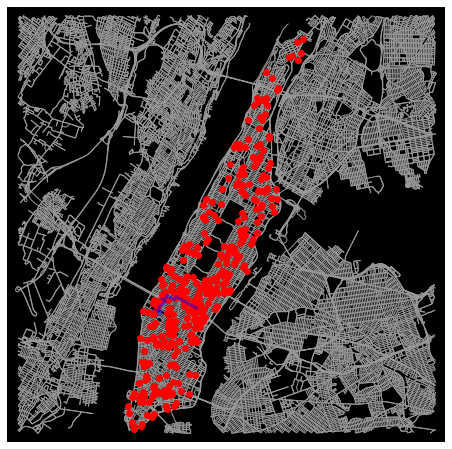

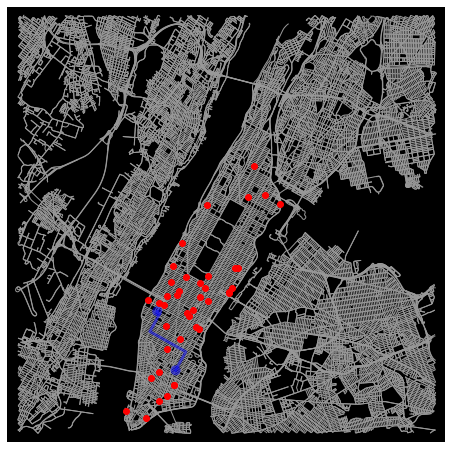

In [ ]:
proba = predictor.process_user(u, to_plot=True)

In [ ]:
u.set_proba(proba, 9)
u.get_proba()

0.05587517288685146

## Сохранение готовых данных

In [ ]:
data.to_csv('/content/final_data/accidents_final.csv')
weather_df.to_csv('/content/final_data/weather_final.csv')
data_ny_tv.to_csv('/content/final_data/traffic_value.csv')
data_manhattan.to_csv('/content/final_data/manhattan_data.csv')
vt_ny.to_csv('/content/final_data/ny_vt.csv')

## Обработка полученной вероятности

### Подгрузка данных

In [ ]:
os.environ['KAGGLE_USERNAME'] = "igorlukhnev"
os.environ['KAGGLE_KEY'] = "403bfdeb083a2fb5bb34353bb5fcb491"

In [ ]:
!kaggle datasets download -d igorlukhnev/mahattan-road-accidents

 47% 9.00M/19.2M [00:00<00:00, 31.7MB/s]
100% 19.2M/19.2M [00:00<00:00, 55.2MB/s]


In [ ]:
!mkdir data_manhattan & unzip mahattan-road-accidents.zip -d final_data

Archive:  mahattan-road-accidents.zip
  inflating: final_data/accidents_final.csv  
  inflating: final_data/manhattan_data.csv  
  inflating: final_data/traffic_value.csv  
  inflating: final_data/weather_final.csv  


In [ ]:
data = pd.read_csv('final_data/accidents_final.csv', index_col=0)
data_manhattan = pd.read_csv('final_data/manhattan_data.csv', index_col=0)
data_ny_tv = pd.read_csv('final_data/traffic_value.csv', index_col=0)
weather_df = pd.read_csv('final_data/weather_final.csv', index_col=0)
tv_ny = pd.read_csv('/content/final_data/ny_vt.csv')

In [ ]:
data.head()

,car_type,month,day_of_week,time_period,edge,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT11,WT13,WT14,WT16,WT18,WT19,WT22,without_driver_troubles,isaccident
0,sedan,4,4,1:00-2:00AM,"(40.77161, -73.99046)",5.37,0.0,0.07,0.0,0.0,0.0,51,36,0.0,220.0,220.0,14.1,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,station wagon/sport utility vehicle,12,3,12:00-1:00PM,"(40.7602, -73.996864)",5.14,0.0,0.48,0.0,0.0,0.0,48,36,0.0,300.0,300.0,15.0,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,truck,12,3,12:00-1:00PM,"(40.7602, -73.996864)",5.14,0.0,0.48,0.0,0.0,0.0,48,36,0.0,300.0,300.0,15.0,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,van,5,6,12:00-1:00 AM,"(40.84103, -73.94463)",7.38,0.0,0.00,0.0,0.0,0.0,64,39,0.0,250.0,230.0,18.1,29.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,sedan,5,6,12:00-1:00 AM,"(40.84103, -73.94463)",7.38,0.0,0.00,0.0,0.0,0.0,64,39,0.0,250.0,230.0,18.1,29.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [ ]:
data_manhattan.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,month,day_of_week,time_period
30,04/16/2021,21:20,MANHATTAN,10025.0,40.793350,-73.972750,"(40.79335, -73.97275)",WEST 94 STREET,BROADWAY,NaN,0.0,0.0,0,0,0,0,0,0,Backing Unsafely,Unspecified,NaN,NaN,NaN,4407958,Sedan,NaN,NaN,NaN,NaN,4,4,9:00-10:00PM
31,04/16/2021,17:20,MANHATTAN,10012.0,40.725380,-74.000110,"(40.72538, -74.00011)",PRINCE STREET,WOOSTER STREET,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4407885,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,4,4,5:00-6:00PM
72,04/16/2021,20:55,MANHATTAN,10032.0,40.841717,-73.944350,"(40.841717, -73.94435)",NaN,NaN,1051 RIVERSIDE DRIVE,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4408280,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,4,4,8:00-9:00PM
83,04/15/2021,22:25,MANHATTAN,10036.0,40.760822,-73.998320,"(40.760822, -73.99832)",WEST 42 STREET,11 AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,4407830,Sedan,NaN,NaN,NaN,NaN,4,3,10:00-11:00PM
84,04/14/2021,10:09,MANHATTAN,10016.0,40.746080,-73.974945,"(40.74608, -73.974945)",2 AVENUE,EAST 36 STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4407282,Tow Truck / Wrecker,Dump,NaN,NaN,NaN,4,2,10:00-11:00AM


In [ ]:
data_ny_tv.head()

,edge,DATE,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,3:00-4:00AM,4:00-5:00AM,5:00-6:00AM,6:00-7:00AM,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM,day_of_week,month
0,"(42720018, 2024978445, 0)",2014-09-13,94.0,73.0,65.0,61.0,64.0,73.0,65.0,113.0,169.0,210.0,182.0,245.0,244,233,280,272,264,236,213,190,199,183,147,103,5,9
1,"(42720018, 2024978445, 0)",2014-09-13,88.0,82.0,75.0,60.0,65.0,67.0,71.0,142.0,198.0,212.0,205.0,237.0,257,245,237,276,223,240,217,198,186,162,157,103,5,9
2,"(42421745, 42428751, 0)",2014-09-13,255.0,209.0,149.0,148.0,128.0,136.0,199.0,354.0,473.0,567.0,634.0,781.0,785,779,732,809,707,675,641,556,546,465,425,324,5,9
3,"(42421745, 42428751, 0)",2014-09-13,255.0,209.0,149.0,148.0,128.0,136.0,199.0,354.0,473.0,567.0,634.0,781.0,785,779,732,809,707,675,641,556,546,465,425,324,5,9
4,"(42421745, 42428751, 0)",2014-09-13,87.0,86.0,78.0,56.0,47.0,80.0,98.0,133.0,171.0,177.0,215.0,235.0,239,257,200,200,209,175,181,167,144,129,112,103,5,9


In [ ]:
weather_df.head()

,month,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT11,WT13,WT14,WT16,WT18,WT19,WT22,without_driver_troubles
0,1,6.04,0.0,0.05,0.0,0.0,0.0,52,41,0.0,150.0,150.0,15.0,21.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,1,10.29,0.0,0.00,0.0,0.0,0.0,50,33,0.0,270.0,270.0,25.1,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1,10.51,0.0,0.00,0.0,0.0,0.0,33,15,0.0,290.0,280.0,19.9,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1,7.61,0.0,0.00,0.0,0.0,0.0,27,13,0.0,290.0,310.0,16.1,21.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1,6.26,0.0,0.00,0.0,0.0,0.0,40,27,0.0,300.0,320.0,16.1,21.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
